<a href="https://colab.research.google.com/github/Jitmandal051004/Rice_type_Classification/blob/main/Rice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialization


In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jitmandal24
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.77MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Pre_processing

In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [6]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
print(data_df["Class"].unique())
print(data_df["Class"].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


### Normalization

In [8]:
orig_data_df = data_df.copy()

for col in data_df.columns:
  data_df[col] = (data_df[col] / data_df[col].abs().max())

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [9]:
X = np.array(data_df.iloc[:, :-1]) #all values except last col
Y = np.array(data_df.iloc[:, -1]) #last col

print(X.shape, Y.shape)

(18185, 10) (18185,)


### Splitting of the dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape, X_test.shape, X_val.shape)

(12729, 10) (2728, 10) (2728, 10)


### Dataset object


In [11]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device) #vector
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [12]:
training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

### Data_loader


In [13]:
batch_size = 32

In [14]:
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size= batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size= batch_size, shuffle=True)

In [15]:
for x, y in train_dataloader:
  print(x)
  print("========")
  print(y)
  break

tensor([[0.5710, 0.8008, 0.6373, 0.9656, 0.5550, 0.7557, 0.7365, 0.6655, 0.7072,
         0.7129],
        [0.9175, 0.9038, 0.8811, 0.9292, 0.8653, 0.9579, 0.9075, 0.7670, 0.8554,
         0.5819],
        [0.5941, 0.7936, 0.6558, 0.9600, 0.5623, 0.7708, 0.6074, 0.6458, 0.7813,
         0.6866],
        [0.8921, 0.8967, 0.8608, 0.9326, 0.8415, 0.9445, 0.6331, 0.7557, 0.8567,
         0.5910],
        [0.8002, 0.8620, 0.8069, 0.9379, 0.7548, 0.8945, 0.6690, 0.7261, 0.8324,
         0.6061],
        [0.6449, 0.7387, 0.7646, 0.9150, 0.6175, 0.8030, 0.7105, 0.6454, 0.8490,
         0.5481],
        [0.5569, 0.7970, 0.6071, 0.9715, 0.5297, 0.7463, 0.5715, 0.6474, 0.7287,
         0.7448],
        [0.6061, 0.7331, 0.7185, 0.9280, 0.5744, 0.7785, 0.7369, 0.6252, 0.8505,
         0.5789],
        [0.5212, 0.7466, 0.6131, 0.9610, 0.4950, 0.7219, 0.8364, 0.6149, 0.7559,
         0.6909],
        [0.6035, 0.8581, 0.6221, 0.9776, 0.5788, 0.7769, 0.5626, 0.6857, 0.7039,
         0.7826],
        [0

### model

In [16]:
HIDDEN_NEURONS = 10

In [17]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__() #here we will use the constructor of the nn module

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x): #define the flow of the data in the model
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

### Create Summary


In [18]:
summary(model, (X.shape[1],)) #-1 shows batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Loss and Optimizer



In [19]:
criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=1e-3)

In [20]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
  total_loss_train = 0
  total_acc_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for data in train_dataloader:
    inputs, labels = data # batch size * batch size

    prediction = model(inputs).squeeze(1) #convert torch.Size([8, 1]) to torch.Size([8]) if used 1

    #loss
    batch_loss = criterion(prediction, labels) # loss after every each epoch
    total_loss_train += batch_loss.item() # after all epoch

    #accuracy
    acc = ((prediction).round() == labels).sum().item() #.item() convert tensor to main item
    total_acc_train += acc

    batch_loss.backward() #from other side
    optimizer.step() #initiate and steps optimmizer to change the weight and restart again, prevent non-convergences
    optimizer.zero_grad()

  with torch.no_grad(): #prepare the model for prediction without changing the model perimeters
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      #loss
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item() # after all epoch

      #accuracy
      acc = ((prediction).round() == labels).sum().item() #.item() convert tensor to main item
      total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train / 1000, 4)) #round fn
    total_loss_val_plot.append(round(total_loss_val / 1000, 4)) #used to rounding

    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4)) # training_data.__len__() --> length of the data
    total_acc_val_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))

    print(f'''Epoch no. {epoch+1}
              Train Loss: {round(total_loss_train / 1000, 4)}
              Val Loss: {round(total_loss_val / 1000, 4)}
              Train Acc: {total_acc_train_plot[-1]}
              Val Acc: {total_acc_val_plot[-1]}''') #two mtds of representing the value
    print("="*25)

Epoch no. 1 
              Train Loss: 0.2406
              Val Loss: 0.0393 
              Train Acc: 81.7346 
              Val Acc: 97.1408
Epoch no. 2 
              Train Loss: 0.1223
              Val Loss: 0.0164 
              Train Acc: 97.8867 
              Val Acc: 98.6437
Epoch no. 3 
              Train Loss: 0.0557
              Val Loss: 0.009 
              Train Acc: 98.2952 
              Val Acc: 98.7537
Epoch no. 4 
              Train Loss: 0.035
              Val Loss: 0.0062 
              Train Acc: 98.4445 
              Val Acc: 98.6804
Epoch no. 5 
              Train Loss: 0.0268
              Val Loss: 0.0051 
              Train Acc: 98.4916 
              Val Acc: 98.717
Epoch no. 6 
              Train Loss: 0.0228
              Val Loss: 0.0044 
              Train Acc: 98.5545 
              Val Acc: 98.7537
Epoch no. 7 
              Train Loss: 0.0206
              Val Loss: 0.0042 
              Train Acc: 98.5545 
              Val Acc: 98.8636
Ep

### Testing Dataset


In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f'''Test Loss: {round(total_loss_test / 1000, 4)}
Test Acc: {round(total_acc_test / testing_data.__len__() * 100, 4)}''')

Test Loss: 0.0042 
Test Acc: 98.5704


### Visualization

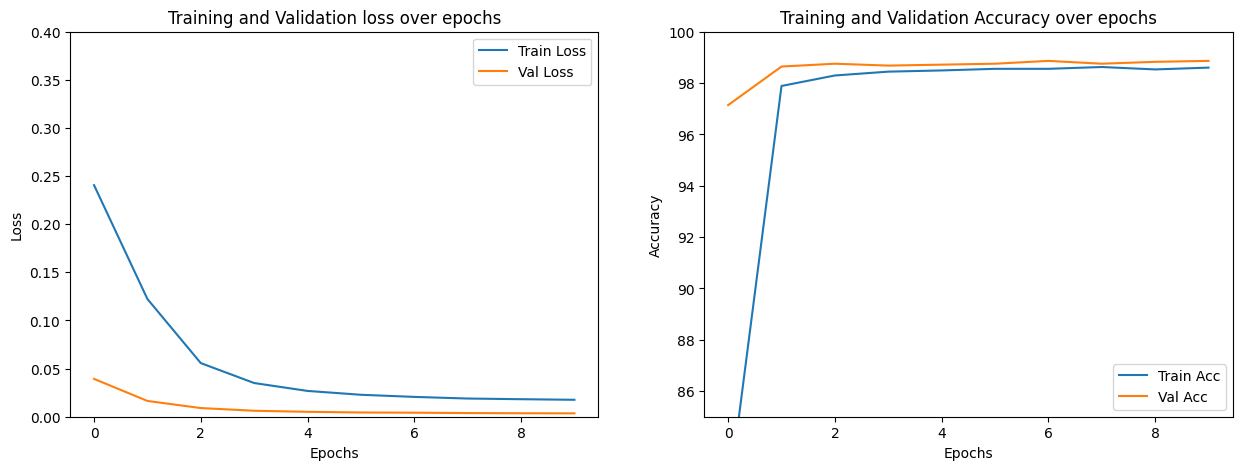

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Val Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.4])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Acc")
axs[1].plot(total_acc_val_plot, label="Val Acc")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([85,100])
axs[1].legend()

plt.show()

### Prediction Inference

In [28]:
area = 2353 / orig_data_df['Area'].abs().max()

MajorAxisLength = 81 / orig_data_df['MajorAxisLength'].abs().max()

MinorAxisLength = 42 / orig_data_df['MinorAxisLength'].abs().max()

Eccentricity = 32 / orig_data_df['Eccentricity'].abs().max()

ConvexArea = 12 / orig_data_df['ConvexArea'].abs().max()

EquivDiameter = 33 / orig_data_df['EquivDiameter'].abs().max()

Extent = 98 / orig_data_df['Extent'].abs().max()

Perimeter = 927 / orig_data_df['Perimeter'].abs().max()

Roundness = 677 / orig_data_df['Roundness'].abs().max()

AspectRation = 24 / orig_data_df['AspectRation'].abs().max()

My_Prediction = model(torch.tensor([area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation], dtype = torch.float32).to(device))

In [30]:
My_Prediction

tensor([0.], device='cuda:0', grad_fn=<SigmoidBackward0>)